In [2]:
import os
import sys
from tqdm import trange
from tqdm import tqdm
from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

In [3]:
print("Version:", medmnist.__version__)

Version: 0.2.2


In [144]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True
# input_root = 'tmp_data/'
input_root = 'input/'

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

flag_to_class = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

DataClass = flag_to_class[data_flag]

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [145]:
# preprocessing
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=1, contrast=1, hue=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

# load the data
train_dataset = DataClass(root=input_root, split='train', transform=data_transform, download=download)
test_dataset = DataClass(root=input_root, split='test', transform=data_transform, download=download)
nonorm_dataset = DataClass(root=input_root, split='train', transform=transforms.ToTensor(), download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: input/pathmnist.npz
Using downloaded and verified file: input/pathmnist.npz
Using downloaded and verified file: input/pathmnist.npz


In [110]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(nonorm_dataset)

Dataset PathMNIST
    Number of datapoints: 89996
    Root location: input/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: PathMNIST: A dataset based on a prior study for predicting survival from colorectal cancer histology slides, which provides a dataset NCT-CRC-HE-100K of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset CRC-VAL-HE-7K of 7,180 image patches from a different clinical center. 9 types of tissues are involved, resulting a multi-class classification task. We resize the source images of 3 x 224 x 224 into 3 x 28 x 28, and split NCT-CRC-HE-100K into training and valiation set with

[5]


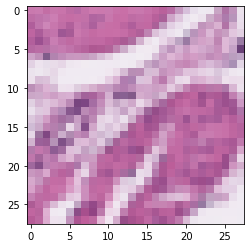

In [154]:
# visualization

img, target = nonorm_dataset[8]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)
print(target)

In [142]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j],cmap='gray')
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y,num_rows,num_cols,scale)

In [155]:
print(img.shape)
img = img.permute(2, 0, 1)
image = img.cpu().clone()
image = image.squeeze(0) # 压缩一维
print(image.shape)
unloader = transforms.ToPILImage()
# image = transforms.ToPILImage(image) # 自动转换为0-255
# image = unloader(image)
image = transforms.ToPILImage()(image)
print(image)

torch.Size([28, 28, 3])
torch.Size([3, 28, 28])
<PIL.Image.Image image mode=RGB size=28x28 at 0x18F2C28CDA0>


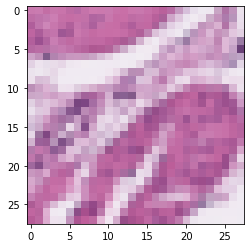

In [156]:
plt.imshow(image)

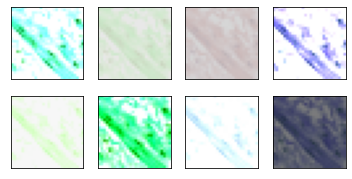

In [124]:
apply(image,transforms.ColorJitter(brightness=1, contrast=1, hue=0.5, saturation=0.5))

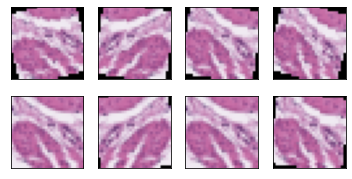

In [157]:
augs = transforms.Compose(
            [transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomCrop(28),
#             transforms.ColorJitter(brightness=0.5, contrast=1, hue=0.5, saturation=0.5),
            transforms.RandomRotation(15)])
apply(image,augs)

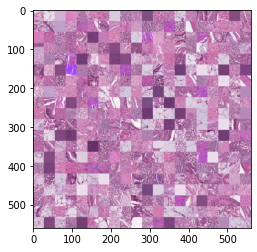

In [63]:
# montage

def process(n_channels, length=20):
    scale = length * length

    image = np.zeros((scale, 28, 28, 3)) if n_channels == 3 else np.zeros((scale, 28, 28))
    index = [i for i in range(scale)]
    np.random.shuffle(index)
    
    for idx in range(scale):
        img, _ = nonorm_dataset[idx]
        if n_channels == 3:
            img = img.permute(1, 2, 0).numpy()
        else:
            img = img.reshape(28, 28).numpy()
        image[index[idx]] = img

    if n_channels == 1:
        image = image.reshape(scale, 28, 28)
        arr_out = montage(image)
        plt.imshow(arr_out, cmap='gray')
    else:
        image = image.reshape(scale, 28, 28, 3)
        arr_out = montage(image, multichannel=3)
        plt.imshow(arr_out)
    
process(n_channels=n_channels, length=20)

Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [8]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Next, we can start to train and evaluate!

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

 51%|█████▏    | 19/37 [00:05<00:04,  3.72it/s]

In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                m = nn.Sigmoid()
                outputs = m(outputs)
            else:
                targets = targets.squeeze().long()
                m = nn.Softmax(dim=1)
                outputs = m(outputs)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
    
        print('%s  acc: %.3f  auc:%.3f' % (split, acc, auc))

        
print('==> Evaluating ...')
test('train')
test('test')